# MNIST classification example with TensorFlow

## Install packages on Google  Cloud Datalab (locally use conda env)
### Select in the Python3 Kernel:
In the menu bar the of 'Kernel', select   
**python3**
### Install needed packages
copy the command below in a Google Cloud Datalab cell  
**!pip install tensorflow==1.12**
### Restart the Kernel 
this is to take into account the new installed packages. Click in the menu bar on:  
**Reset Session**

## Needed librairies

In [51]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import gzip
import sys
import _pickle as cPickle

In [52]:
tf.__version__

'1.12.0'

## Import the Data

In [53]:
# get mnist data, split between train and test sets
# on GCP
#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# with AXA network
def load_data(path):
    f = gzip.open(path, 'rb')
    if sys.version_info < (3,):
        data = cPickle.load(f)
    else:
        data = cPickle.load(f, encoding='bytes')
    f.close()
    return data
(x_train, y_train), (x_test, y_test) = load_data(path='../data/mnist.pkl.gz')

In [54]:
# check data shape (training)
x_train.shape

(60000, 28, 28)

In [55]:
# check data shape (train)
x_test.shape

(10000, 28, 28)

In [56]:
x_train.dtype, x_test.dtype

(dtype('uint8'), dtype('uint8'))

In [57]:
np.max(x_train), np.min(x_train), np.max(x_test), np.min(x_test)  

(255, 0, 255, 0)

## Normalize and reorganize the data

In [58]:
# cast uint8 -> float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [59]:
# renormalize the data 255 grey variation
x_train /= 255
x_test /= 255

In [60]:
# reshape the data 28 x 28 -> 784
x_train = x_train.reshape(len(x_train), x_train.shape[1]*x_train.shape[2])
x_test = x_test.reshape(len(x_test), x_test.shape[1]*x_test.shape[2])

In [61]:
x_train.shape

(60000, 784)

In [62]:
x_test.shape

(10000, 784)

## Reshape the labels

In [63]:
y_train.shape

(60000,)

In [64]:
y_test.shape

(10000,)

In [65]:
np.unique(y_train), np.unique(y_test)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8))

In [66]:
num_classes = len(np.unique(y_train))
num_classes

10

In [67]:
# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [68]:
y_train.shape

(60000, 10)

In [69]:
y_test.shape

(10000, 10)

In [70]:
dim_input=x_train.shape[1]
dim_input

784

## Visualize the data

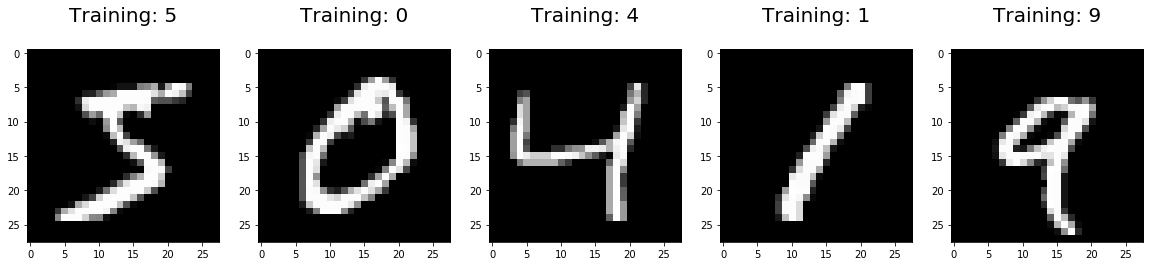

In [71]:
plt.figure(figsize=(20,4))
for index, (image, label) in enumerate(zip(x_train[0:5], y_train[0:5])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.title('Training: %i\n' % np.argmax(label), fontsize = 20)

## Defined some hyperparameters

In [72]:
# learning rate
learning_rate = 0.5

# number of epoch to train our model
EPOCHS = 1

# size of our mini batch
#BATCH_SIZE = len(x_train)
BATCH_SIZE = 128

# shuffle buffer size
SHUFFLE_BUFFER_SIZE = 10 * BATCH_SIZE

# prefetch buffer size
PREFETCH_BUFFER_SIZE = 1 #tf.contrib.data.AUTOTUNE

# number of paralell calls
NUM_PARALELL_CALL = 4

# hidden layer 1
n1=300

In [73]:
BATCH_SIZE, EPOCHS

(128, 1)

## Defined flags

In [74]:
def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()    
    keys_list = [keys for keys in flags_dict]    
    for keys in keys_list:
        FLAGS.__delattr__(keys)
    
del_all_flags(tf.flags.FLAGS)

In [75]:
tf.app.flags.DEFINE_string('f', '', 'kernel') # just for jupyter notebook and avoir : "UnrecognizedFlagError: Unknown command line flag 'f'"
tf.app.flags.DEFINE_string('model_dir', '../results/Models/Mnist/ckpt/', 'Dir to save a model and checkpoints')
tf.app.flags.DEFINE_string('saved_dir', '../results/Models/Mnist/pb/', 'Dir to save a model for TF serving')
tf.app.flags.DEFINE_integer('shuffle_buffer_size', SHUFFLE_BUFFER_SIZE , 'Shuffle buffer size')
tf.app.flags.DEFINE_integer('prefetch_buffer_size', PREFETCH_BUFFER_SIZE, 'Prefetch buffer size')
tf.app.flags.DEFINE_integer('batch_size', BATCH_SIZE, 'Batch size')
tf.app.flags.DEFINE_integer('num_parallel_calls', NUM_PARALELL_CALL, 'Number of paralell calls')
FLAGS = tf.app.flags.FLAGS

In [76]:
print(FLAGS)


/Users/tarrade/anaconda3/envs/env_gcp_dl/lib/python3.6/site-packages/ipykernel_launcher.py:
  --batch_size: Batch size
    (default: '128')
    (an integer)
  --f: kernel
    (default: '')
  --model_dir: Dir to save a model and checkpoints
    (default: '../results/Models/Mnist/ckpt/')
  --num_parallel_calls: Number of paralell calls
    (default: '4')
    (an integer)
  --prefetch_buffer_size: Prefetch buffer size
    (default: '1')
    (an integer)
  --saved_dir: Dir to save a model for TF serving
    (default: '../results/Models/Mnist/pb/')
  --shuffle_buffer_size: Shuffle buffer size
    (default: '1280')
    (an integer)

absl.flags:
  --flagfile: Insert flag definitions from the given file into the command line.
    (default: '')
  --undefok: comma-separated list of flag names that it is okay to specify on
    the command line even if the program does not define a flag with that name.
    IMPORTANT: flags in this list that have arguments MUST use the --flag=value
    format.
   

## Using tf.data.Dataset
https://www.tensorflow.org/guide/performance/datasets  
To summarize, one good order for the different transformations is:
- create the dataset
- shuffle (with a big enough buffer size)
- repeat
- map with the actual work (preprocessing, augmentation…) using multiple parallel calls
- batch
- prefetch

ModeKeys:  
https://www.tensorflow.org/api_docs/python/tf/estimator/ModeKeys  
- EVAL
- PREDICT
- TRAIN

In [77]:
def input_dataset_fn(x_data, y_data, batch_size=128, mode=tf.estimator.ModeKeys.TRAIN):
    
    # 1) convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data))
    
    # 2) shuffle (with a big enough buffer size)    :        
    if mode == tf.estimator.ModeKeys.TRAIN:
        num_epochs = None # loop indefinitely
        dataset = dataset.shuffle(buffer_size=FLAGS.shuffle_buffer_size, seed=2)# depends on sample size
    else:
        num_epochs = 1 # end-of-input after this
        
    # caching data
    #dataset = dataset.cache()
    
    # 3) automatically refill the data queue when empty
    dataset = dataset.repeat(num_epochs)
    
    # 4) map
    #dataset = dataset.map(map_func=parse_fn, num_parallel_calls=FLAGS.num_parallel_calls)

    # 5) create batches of data
    dataset = dataset.batch(batch_size=batch_size, drop_remainder=True)
    
    # 6) prefetch data for faster consumption, based on your system and environment, allows the tf.data runtime to automatically tune the prefetch buffer sizes
    dataset = dataset.prefetch(FLAGS.prefetch_buffer_size)

    return dataset

In [78]:
training_dataset = input_dataset_fn(x_train, 
                                    y_train, 
                                    mode=tf.estimator.ModeKeys.TRAIN, 
                                    batch_size=FLAGS.batch_size)
testing_dataset = input_dataset_fn(x_test, 
                                   y_test,
                                   mode=tf.estimator.ModeKeys.EVAL, 
                                   batch_size=len(x_test))

### exploration dataset API

In [102]:
iterator = training_dataset.make_one_shot_iterator()

In [103]:
# next_element
features, labels = iterator.get_next()

In [104]:
len(x_train)/BATCH_SIZE

468.75

In [105]:
n=0
n_iter=470
with tf.Session() as sess:
    while True:
        try:
            start_time = time.clock()
            x,y = sess.run([features, labels])
            print('iteration n:', n, 'execution time:', time.clock() - start_time, 'seconds')
            print(x.shape)
            print(y.shape)
            print('first label of the batch',np.argmax(y[0]),'\n')
            n+=1
            if n>=n_iter:
                print('number of iteration reached')
                break
        except tf.errors.OutOfRangeError:
            print('tf.errors.OutOfRangeError')
            break

iteration n: 0 execution time: 18.565196000000014 seconds
(128, 784)
(128, 10)
first label of the batch 9 

iteration n: 1 execution time: 0.009054999999989377 seconds
(128, 784)
(128, 10)
first label of the batch 2 

iteration n: 2 execution time: 0.0018800000000283035 seconds
(128, 784)
(128, 10)
first label of the batch 6 

iteration n: 3 execution time: 0.00483299999996234 seconds
(128, 784)
(128, 10)
first label of the batch 1 

iteration n: 4 execution time: 0.002751999999986765 seconds
(128, 784)
(128, 10)
first label of the batch 5 

iteration n: 5 execution time: 0.005135999999993146 seconds
(128, 784)
(128, 10)
first label of the batch 1 

iteration n: 6 execution time: 0.004634999999893807 seconds
(128, 784)
(128, 10)
first label of the batch 9 

iteration n: 7 execution time: 0.00405799999998635 seconds
(128, 784)
(128, 10)
first label of the batch 8 

iteration n: 8 execution time: 0.004253000000062457 seconds
(128, 784)
(128, 10)
first label of the batch 2 

iteration n: 

iteration n: 125 execution time: 0.004672000000027765 seconds
(128, 784)
(128, 10)
first label of the batch 7 

iteration n: 126 execution time: 0.0034780000000864675 seconds
(128, 784)
(128, 10)
first label of the batch 9 

iteration n: 127 execution time: 0.0038829999999734355 seconds
(128, 784)
(128, 10)
first label of the batch 3 

iteration n: 128 execution time: 0.0035820000000512664 seconds
(128, 784)
(128, 10)
first label of the batch 1 

iteration n: 129 execution time: 0.0038430000000744258 seconds
(128, 784)
(128, 10)
first label of the batch 7 

iteration n: 130 execution time: 0.003999000000021624 seconds
(128, 784)
(128, 10)
first label of the batch 6 

iteration n: 131 execution time: 0.0038700000000062573 seconds
(128, 784)
(128, 10)
first label of the batch 6 

iteration n: 132 execution time: 0.004262000000039734 seconds
(128, 784)
(128, 10)
first label of the batch 3 

iteration n: 133 execution time: 0.00410999999996875 seconds
(128, 784)
(128, 10)
first label of th

iteration n: 252 execution time: 0.004599999999982174 seconds
(128, 784)
(128, 10)
first label of the batch 2 

iteration n: 253 execution time: 0.004543000000012398 seconds
(128, 784)
(128, 10)
first label of the batch 1 

iteration n: 254 execution time: 0.003969999999981155 seconds
(128, 784)
(128, 10)
first label of the batch 5 

iteration n: 255 execution time: 0.004096000000004096 seconds
(128, 784)
(128, 10)
first label of the batch 4 

iteration n: 256 execution time: 0.004114999999956126 seconds
(128, 784)
(128, 10)
first label of the batch 4 

iteration n: 257 execution time: 0.003939999999943211 seconds
(128, 784)
(128, 10)
first label of the batch 5 

iteration n: 258 execution time: 0.005499999999983629 seconds
(128, 784)
(128, 10)
first label of the batch 0 

iteration n: 259 execution time: 0.0055690000000367945 seconds
(128, 784)
(128, 10)
first label of the batch 8 

iteration n: 260 execution time: 0.006074000000012347 seconds
(128, 784)
(128, 10)
first label of the b

iteration n: 379 execution time: 0.0044440000000349755 seconds
(128, 784)
(128, 10)
first label of the batch 2 

iteration n: 380 execution time: 0.004541000000017448 seconds
(128, 784)
(128, 10)
first label of the batch 2 

iteration n: 381 execution time: 0.004008999999996377 seconds
(128, 784)
(128, 10)
first label of the batch 0 

iteration n: 382 execution time: 0.004067999999961103 seconds
(128, 784)
(128, 10)
first label of the batch 6 

iteration n: 383 execution time: 0.004362000000014632 seconds
(128, 784)
(128, 10)
first label of the batch 2 

iteration n: 384 execution time: 0.004237999999986641 seconds
(128, 784)
(128, 10)
first label of the batch 7 

iteration n: 385 execution time: 0.004960999999980231 seconds
(128, 784)
(128, 10)
first label of the batch 3 

iteration n: 386 execution time: 0.006662000000005719 seconds
(128, 784)
(128, 10)
first label of the batch 9 

iteration n: 387 execution time: 0.004202999999961321 seconds
(128, 784)
(128, 10)
first label of the b

In [106]:
iterator = testing_dataset.make_one_shot_iterator()

In [107]:
# next_element
features, labels = iterator.get_next()

In [108]:
with tf.Session() as sess:
    while True:
        try:
            start_time = time.clock()
            x,y = sess.run([features, labels])
            print(time.clock() - start_time, 'seconds')
            print(x.shape)
            print(y.shape)
            print('first label of the batch',np.argmax(y[0]),'\n')
        except tf.errors.OutOfRangeError:
            print('tf.errors.OutOfRangeError')
            break

6.578711999999996 seconds
(10000, 784)
(10000, 10)
first label of the batch 7 

tf.errors.OutOfRangeError


### Keras Call back

In [26]:
class UDFPrint(tf.keras.callbacks.Callback):
    def __init__(self, test_data):
        self.test_data = test_data
        
    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        _, __, x_train, y_train = self.test_data
        loss_train, acc_train = self.model.evaluate(x_train, y_train, verbose=0)
        print('Reached epoch {0:3d} cost J = {1:.5f}'.format(epoch, loss_train))
        return

    def on_epoch_end(self, epoch, logs={}):
        x_test, y_test, x_train, y_train = self.test_data
        loss_train, acc_train = self.model.evaluate(x_train, y_train, verbose=0)
        loss_test, acc_test = self.model.evaluate(x_test, y_test, verbose=0)
        print(' accurary on the training set {0:.4f}'.format(acc_train))
        print(' accurary on the testing set {0:.4f}'.format(acc_test))

    def on_batch_begin(self, batch, logs={}):
        #print('  ---> starting minibatch', batch)
        return

    def on_batch_end(self, batch, logs={}):
        #print('  ---> ending minibatch', batch)
        return
return

## Defined our model

In [27]:
def baseline_model():
    # create model
    model = tf.keras.Sequential()
 
    # hidden layer
    model.add(tf.keras.layers.Dense(dim_input, 
                    input_dim=dim_input, 
                    kernel_initializer=tf.keras.initializers.he_normal(),
                    bias_initializer=tf.keras.initializers.Zeros(),
                    activation='relu'))
    # last layer
    model.add(tf.keras.layers.Dense(num_classes, 
                    kernel_initializer=tf.keras.initializers.he_normal(),
                    bias_initializer=tf.keras.initializers.Zeros(),
                    activation='softmax'))
    
    # weight initialisation
    # He: keras.initializers.he_normal(seed=None)
    # Xavier: keras.initializers.glorot_uniform(seed=None)
    # Radom Normal: keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
    # Truncated Normal: keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=None)
    
    # optimiser
    optimiser=tf.keras.optimizers.Adam(lr=0.01, beta_1=0.9)
    # GD/SGC: keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
    # Adam: keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    # RMSProp: keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
    # Momentum: keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0, nesterov=False)
    
    # Compile model
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimiser, 
                  metrics=['accuracy'])
    return model

In [28]:
# build the model
model = baseline_model()

In [29]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 784)               615440    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                7850      
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
_________________________________________________________________


## Store the original weights

In [30]:
initial_weights = model.get_weights()

## Fit the model using numpy array  
- batch_size 
  determines the number of samples in each mini batch. Its maximum is the number of all samples, which makes gradient descent accurate, the loss will decrease towards the minimum if the learning rate is small enough, but iterations are slower. Its minimum is 1, resulting in stochastic gradient descent: Fast but the direction of the gradient step is based only on one example, the loss may jump around. batch_size allows to adjust between the two extremes: accurate gradient direction and fast iteration. Also, the maximum value for batch_size may be limited if your model + data set does not fit into the available (GPU) memory.
- steps_per_epoch 
  the number of batch iterations before a training epoch is considered finished. If you have a training set of fixed size you can ignore it but it may be useful if you have a huge data set or if you are generating random data augmentations on the fly, i.e. if your training set has a (generated) infinite size. If you have the time to go through your whole training data set I recommend to skip this parameter.
- validation_steps 
  similar to steps_per_epoch but on the validation data set instead on the training data. If you have the time to go through your whole validation data set I recommend to skip this parameter.



In [31]:
# Set to the original weights for testing other pipelines
model.set_weights(initial_weights)

# Fit the model
hist=model.fit(x_train, 
               y_train, 
               validation_data=(x_test, y_test),
               callbacks=[UDFPrint((x_test, y_test, x_train, y_train))],
               epochs=EPOCHS, 
               batch_size=BATCH_SIZE,
               verbose=2)

Train on 60000 samples, validate on 10000 samples
Reached epoch   0 cost J = 2.47134
Epoch 1/1
 accurary on the training set 0.3599
 accurary on the testing set 0.3614
 - 22s - loss: 2.4713 - acc: 0.0710 - val_loss: 3.5724 - val_acc: 0.3614


In [32]:
print(hist.history)

{'val_loss': [3.572427272796631], 'val_acc': [0.3614000082015991], 'loss': [2.4713327884674072], 'acc': [0.07098333537578583]}


In [33]:
score = model.evaluate(x_test, 
                       y_test, 
                       verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 3.572427568054199
Test accuracy: 0.3614


In [34]:
score = model.evaluate(x_train, 
                       y_train, 
                       verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Train loss: 3.5285739298502605
Train accuracy: 0.3599


## Fit the model using data.dataset

In [35]:
# Set to the original weights for testing other pipelines
model.set_weights(initial_weights)

# Fit the model (using data.Dataset)
hist=model.fit(training_dataset.make_one_shot_iterator(),
               steps_per_epoch=len(x_train) // BATCH_SIZE,
               validation_data=testing_dataset.make_one_shot_iterator(),
               validation_steps=len(x_test) // BATCH_SIZE,
               #callbacks=[UDFPrint((x_test, y_test, x_train, y_train))],
               epochs=EPOCHS,
               verbose = 2)

Epoch 1/1
 - 56s - loss: 2.4713 - acc: 0.0710


In [36]:
print(hist.history)

{'loss': [2.4713337421417236], 'acc': [0.07098333537578583]}


In [37]:
score = model.evaluate(x_test, 
                       y_test, 
                       verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 3.5751110137939452
Test accuracy: 0.3614


In [38]:
score = model.evaluate(x_train, 
                       y_train, 
                       verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Train loss: 3.5311397709528607
Train accuracy: 0.35986666666666667


## Fit the model using data.dataset

In [ ]:
! rm -r ../results/Models/Mnist/ckpt

In [1]:
!rmdir /S /Q "../results/Models/Mnist/ckpt"

../results/Models/Mnist/ckpt\eval\events.out.tfevents.1548149889.C054093 - Access is denied.
../results/Models/Mnist/ckpt\events.out.tfevents.1548149619.C054093 - Access is denied.


In [36]:
class TimeHistory(tf.train.SessionRunHook):
    def begin(self):
        self.times = []

    def before_run(self, run_context):
        self.iter_time_start = time.time()

    def after_run(self, run_context, run_values):
        self.times.append(time.time() - self.iter_time_start)

In [37]:
time_hist = TimeHistory()

In [88]:
# the tf.distribute.Strategy API is an easy way to distribute your training across multiple devices/machines
NUM_GPUS = 2
#strategy=None
strategy = tf.contrib.distribute.OneDeviceStrategy('device:CPU:0')
#strategy = tf.contrib.distribute.OneDeviceStrategy('device:GPU:0')
#strategy = tf.contrib.distribute.MirroredStrategy(num_gpus=NUM_GPUS)

# config tf.estimator to use a give strategy
training_config = tf.estimator.RunConfig(train_distribute=strategy,
                                         model_dir=FLAGS.model_dir,
                                         save_summary_steps=20,
                                         save_checkpoints_steps=20)

INFO:tensorflow:Initializing RunConfig with distribution strategies.
INFO:tensorflow:Not using Distribute Coordinator.


In [89]:
# Set to the original weights for testing other pipelines
#model.set_weights(initial_weights)

# transfor keras model to estimator model
estimator_train_model = tf.keras.estimator.model_to_estimator(keras_model=model,
                                                              config=training_config)

INFO:tensorflow:Using the Keras model provided.
INFO:tensorflow:Using config: {'_model_dir': '../results/Models/Mnist/ckpt/', '_tf_random_seed': None, '_save_summary_steps': 20, '_save_checkpoints_steps': 20, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': <tensorflow.contrib.distribute.python.one_device_strategy.OneDeviceStrategy object at 0x0000017A8552C5C0>, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000017A8552C518>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_distribute_co

In [ ]:
!ls ../results/Models/Mnist/ckpt

In [92]:
!dir /B "../results/Models/Mnist/ckpt"

checkpoint
eval
events.out.tfevents.1548149619.C054093
graph.pbtxt
keras
model.ckpt-0.data-00000-of-00001
model.ckpt-0.index
model.ckpt-0.meta
model.ckpt-10.data-00000-of-00001
model.ckpt-10.index
model.ckpt-10.meta


### Training our model

In [41]:
def get_train_input_fn():
    return input_dataset_fn(x_train, y_train, is_training=True, batch_size=BATCH_SIZE)

In [42]:
# Fit the model (using estimator.train and data.Dataset)
#estimator_train_model.train(input_fn=lambda:input_dataset_fn(x_train, y_train, is_training=True, batch_size=BATCH_SIZE),
#                            max_steps=1,
#                            hooks=[time_hist])
estimator_train_model.train(input_fn=get_train_input_fn,
                            #max_steps=1,
                            steps=10,
                            hooks=[time_hist])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='../results/Models/Mnist/ckpt/keras\\keras_model.ckpt', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('../results/Models/Mnist/ckpt/keras\\keras_model.ckpt',)
INFO:tensorflow:Warm-starting variable: dense/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dense/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dense_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dense_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: Adam/iterations; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: Adam/lr; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: Adam/beta_1; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: Adam/beta

### Evaluating the accuracy of our model

In [45]:
score=estimator_train_model.evaluate(input_fn=lambda:input_dataset_fn(x_train, y_train, is_training=False, batch_size=BATCH_SIZE),
                                     steps=1)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-01-22-09:40:44
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../results/Models/Mnist/ckpt/model.ckpt-10
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2019-01-22-09:41:15
INFO:tensorflow:Saving dict for global step 10: accuracy = 0.77631664, global_step = 10, loss = 2.0273774
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 10: ../results/Models/Mnist/ckpt/model.ckpt-10


In [50]:
print('Train loss:', score['loss'])
print('Train accuracy:', score['accuracy'])
print('Train global steps:', score['global_step'])

Train loss: 2.0273774
Train accuracy: 0.77631664
Train global steps: 10


In [55]:
score=estimator_train_model.evaluate(input_fn=lambda:input_dataset_fn(x_test, y_test, is_training=False, batch_size=BATCH_SIZE))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-01-22-09:48:42
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../results/Models/Mnist/ckpt/model.ckpt-10
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-01-22-09:48:46
INFO:tensorflow:Saving dict for global step 10: accuracy = 0.0, global_step = 10, loss = 0.0
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 10: ../results/Models/Mnist/ckpt/model.ckpt-10


In [54]:
print('Test loss:', score['loss'])
print('Test accuracy:', score['accuracy'])
print('Test global steps:', score['global_step'])

Test loss: 0.0
Test accuracy: 0.0
Test global steps: 10


### Generating predictions on our trained model

In [84]:
examples=x_test[0:5]

In [87]:
predictions=list(estimator_train_model.predict(input_fn=lambda:input_dataset_fn(examples, is_training=False, batch_size=BATCH_SIZE)))

ValueError: None values not supported.

In [86]:
for i in range(len(examples)):
    prediction_array = predictions[i].values()[0]
    predicted_label = text_labels[np.argmax(prediction_array)]
    print('Actual label:' + test_tags.iloc[i])
    print("Predicted label: " + predicted_label + "\n")

TypeError: 'generator' object is not subscriptable